In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls 'drive/My Drive'

사진	       MyVideo_1164825922_0002.mp4  Untitled4.ipynb
1989_2019.csv  MyVideo_1164825922_0003.mp4  Untitled5.ipynb
1999_2019.csv  p19992019.csv		    Untitled6.ipynb
20190525.csv   PicsArt_07-17-11.51.34.jpg   Untitled7.ipynb
data	       Untitled0.ipynb		    Untitled8.ipynb
dataset.csv    Untitled1.ipynb		    vcards_20180106_194129.vcf
e19892019.csv  Untitled2.ipynb
heatwave.csv   Untitled3.ipynb


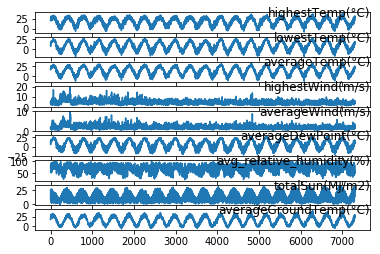

In [4]:
from pandas import read_csv
from matplotlib import pyplot
from matplotlib.pyplot import figure

# load dataset
dataset = read_csv('/content/drive/My Drive/p19992019.csv', header=0, index_col=0, encoding='utf-8') 
values = dataset.values
# specify columns to plot
groups = [1, 2, 3, 4,5,6,7,8,9]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.rcParams["figure.figsize"] = [4,3]
pyplot.show()
#print(dataset)

In [5]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Using TensorFlow backend.


In [6]:
pip install keras

In [7]:
# load dataset
dataset = read_csv('/content/drive/My Drive/p19992019.csv', header=0, index_col=0, encoding='utf-8')
values = dataset.values[:,1:]
dates = dataset.values[:,1]
print(dates)
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1)) #scaling between 0~1, in order to prevent contaminating the experiment with from the test dataset, which might give the model a slight edge
scaled = scaler.fit_transform(values)

# specify the number of lag days
n_days = 8
n_features = 9

# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1) # 2 past observation to forecast 1furture observation
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.shape)
#print(reframed)

[20.1 21.0 22.1 ... 29.8 32.7 30.4]
(7279, 81)


In [8]:
# split into train and test sets
values = reframed.values
n_train_days = 365 * 18    #8years of data to training and the rest to test
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
n_obs = n_days*n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]        #trainX 는 원래 데이터의 2행씩 묶어서 1행을 만듦. vice versa for test_X and test_y
                                                  #trainy는 highest만 갖고옴.
print(train_X.shape[1])
print(train_X.shape, len(train_X), train_y.shape)
print(test_X.shape)
print(test_y.shape)

72
(6570, 72) 6570 (6570,)
(709, 72)
(709,)


In [9]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days ,n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X.shape[1])
print(train_X.shape[2])

(6570, 8, 9) (6570,) (709, 8, 9) (709,)
8
9


W0729 05:10:55.102914 140246509029248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 05:10:55.105663 140246509029248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 05:10:55.112318 140246509029248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 05:10:55.513718 140246509029248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 05:10:55.883268 140246509029248 deprecation.py:323

Train on 6570 samples, validate on 709 samples
Epoch 1/55
 - 8s - loss: 0.1532 - val_loss: 0.0803
Epoch 2/55
 - 3s - loss: 0.0609 - val_loss: 0.0499
Epoch 3/55
 - 3s - loss: 0.0612 - val_loss: 0.0490
Epoch 4/55
 - 3s - loss: 0.0510 - val_loss: 0.0570
Epoch 5/55
 - 3s - loss: 0.0519 - val_loss: 0.0456
Epoch 6/55
 - 3s - loss: 0.0482 - val_loss: 0.0570
Epoch 7/55
 - 3s - loss: 0.0507 - val_loss: 0.0450
Epoch 8/55
 - 3s - loss: 0.0468 - val_loss: 0.0471
Epoch 9/55
 - 3s - loss: 0.0498 - val_loss: 0.0483
Epoch 10/55
 - 3s - loss: 0.0485 - val_loss: 0.0476
Epoch 11/55
 - 3s - loss: 0.0482 - val_loss: 0.0473
Epoch 12/55
 - 3s - loss: 0.0479 - val_loss: 0.0474
Epoch 13/55
 - 3s - loss: 0.0472 - val_loss: 0.0463
Epoch 14/55
 - 3s - loss: 0.0468 - val_loss: 0.0463
Epoch 15/55
 - 3s - loss: 0.0464 - val_loss: 0.0452
Epoch 16/55
 - 3s - loss: 0.0461 - val_loss: 0.0458
Epoch 17/55
 - 3s - loss: 0.0461 - val_loss: 0.0456
Epoch 18/55
 - 3s - loss: 0.0460 - val_loss: 0.0456
Epoch 19/55
 - 3s - loss: 

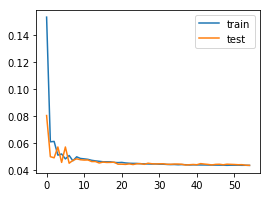

In [10]:
from keras import optimizers
opt = optimizers.Adam(lr=0.012, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))  #30-first hidden layer neurons 
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)
# fit network
history = model.fit(train_X, train_y, epochs=55, batch_size=55, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [11]:
# make a prediction
yhat = model.predict(test_X)
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
print(test_X.shape)
print(yhat.shape)
#print(yhat)

(709, 8, 9)
(709, 72)
(709, 1)


In [12]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -8:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
#print(inv_yhat)
#print(inv_yhat[:,0:1])
inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape)
#print(inv_yhat)

#pyplot.figure()
#pyplot.rcParams["figure.figsize"] = [4,3]
#pyplot.plot(inv_yhat)
#pyplot.show()

(709,)


In [13]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y.shape)
#print(inv_y)

#pyplot.figure()
#pyplot.rcParams["figure.figsize"] = [4,3]
#pyplot.plot(inv_y)
#pyplot.show()

(709,)


In [14]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.674


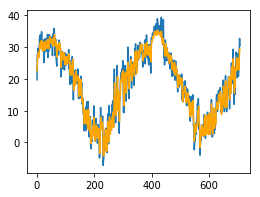

In [15]:
pyplot.figure() 
pyplot.rcParams["figure.figsize"] = [4,3]
pyplot.plot(inv_y) #actual
pyplot.plot(inv_yhat, c='orange') #forecast
pyplot.show()